In [7]:
import numpy as np
import matplotlib.pyplot as plt
import json

import adaptivealgo.cli.policy_iter as pi
from adaptivealgo.lib.simulator import Simulator
from adaptivealgo.lib.env import Environment
import adaptivealgo.cli.simulate_policy as sim
from adaptivealgo.lib.util import trim_state, get_ttl

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams["font.family"] = "Times New Roman"

In [8]:
links = [2, 3, 4, 5, 6, 7]
f_thresh = 0.5
actions = [0.1, 0.2, 0.3, 0.4]
alpha = 1.0
gamma = 0.1
tol = 1e-6

def ratio_std(m_x, sigma_x, m_y, sigma_y):
    return np.sqrt((sigma_x / m_x)**2 + (sigma_y / m_y)**2) * abs(m_x / m_y)

In [9]:
results_path = '../../../results'
policies = {}

for n_links in links:
    file_name = f'{results_path}/output{n_links}.json'
    with open(file_name, 'r') as f:
        results = json.load(f)
        policies[n_links] = results['policy']

print(policies[2])

{'[1]': 0.3, '[2]': 0.4, '[3]': 0.4, '[4]': 0.4, '[5]': 0.4, '[6]': 0.4, '[7]': 0.4, '[]': 0.3, '[8]': 0.4, '[9]': 0.4}


In [10]:
all_actions = {}

for n_links, policy in policies.items():
    all_actions[n_links] = {}
    for state, action in policy.items():
        state_list = json.loads(state)
        state_length = len(state_list)
        if state_length not in all_actions[n_links]:
            all_actions[n_links][state_length] = []
        all_actions[n_links][state_length].append(action)

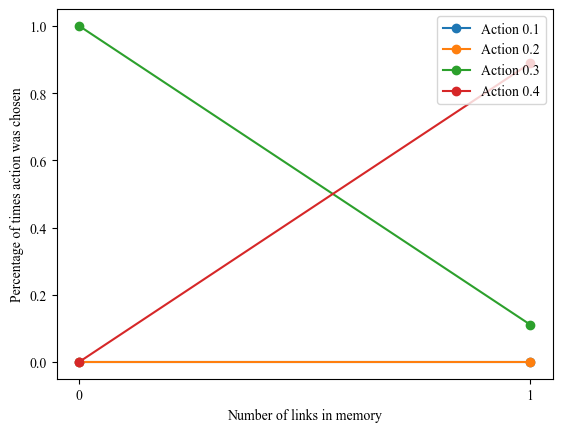

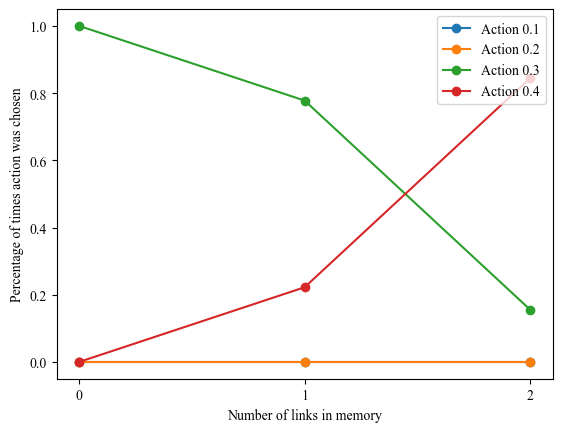

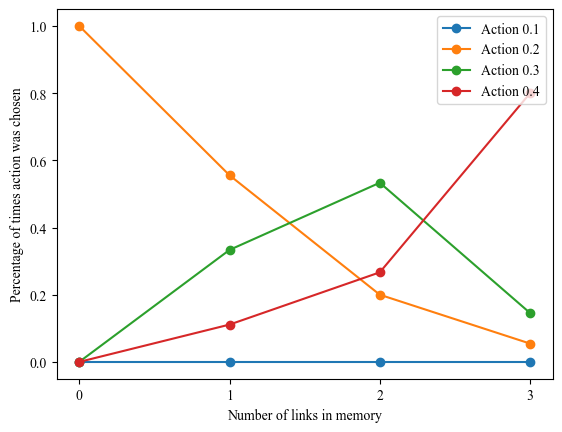

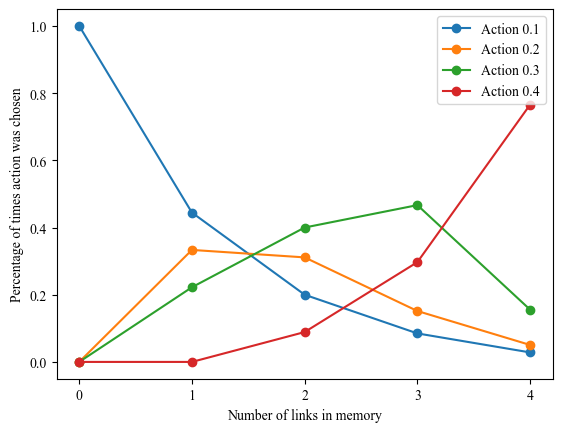

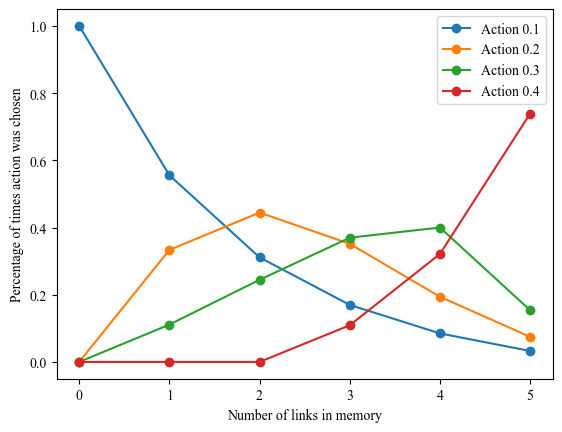

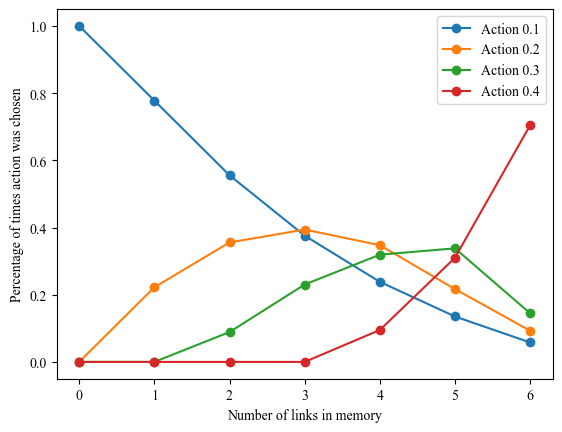

In [11]:
for n_links, policy in all_actions.items():
    actions_chosen = {}
    for state_length, state_actions in policy.items():
        labels, counts = np.unique(state_actions, return_counts=True)
        actions_chosen[state_length] = dict(zip(labels, counts))
    
    for state_length, actions_chosen_state in actions_chosen.items():
        total = sum(actions_chosen_state.values())
        for action, count in actions_chosen_state.items():
            actions_chosen_state[action] = count / total
    
    actions_chosen = dict(sorted(actions_chosen.items()))

    for action in actions:
        y = [actions_chosen[state_length].get(action, 0) for state_length in actions_chosen.keys()]
        plt.plot(list(actions_chosen.keys()), y, label=f"Action {action}", marker='o')
        plt.xticks(np.arange(0, max(actions_chosen.keys()) + 1, 1))

    # plt.title(f"Action distribution against number of links in memory for {n_links} required links")
    plt.xlabel("Number of links in memory")
    plt.ylabel("Percentage of times action was chosen")
    plt.legend(loc='upper right')
    plt.show()

In [12]:
means_opt = []
stds_opt_std = []
stds_opt = []

n_episodes = 10_000

for n_links, policy in policies.items():
    policy = { k: actions.index(v) for k, v in policy.items() }
    simulator = Simulator(policy, n_links, f_thresh, actions, alpha, gamma)
    samples = sim.gen_policy_samples(simulator, n_episodes)
    print(f"Mean runtime for {n_links} required links: {int(np.mean(samples))} steps")

    means_opt.append(np.mean(samples))
    stds_opt_std.append(np.std(samples))
    stds_opt.append(np.std(samples) / np.sqrt(n_episodes))

Mean runtime for 2 required links: 6 steps
Mean runtime for 3 required links: 13 steps
Mean runtime for 4 required links: 30 steps
Mean runtime for 5 required links: 90 steps
Mean runtime for 6 required links: 332 steps
Mean runtime for 7 required links: 1971 steps


Mean runtime: 1964 steps


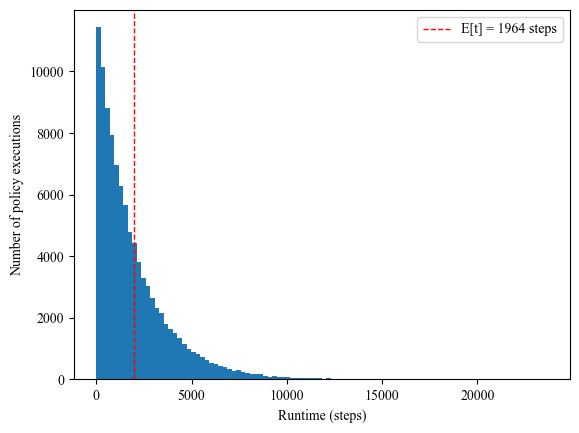

In [13]:
sim_policy = policies[7]
sim_policy = { k: actions.index(v) for k, v in sim_policy.items() }
simulator = Simulator(sim_policy, n_links, f_thresh, actions, alpha, gamma)
samples = sim.gen_policy_samples(simulator, iters=100_000)
print(f"Mean runtime: {int(np.mean(samples))} steps")

plt.hist(samples, bins=100)
plt.axvline(np.mean(samples), color='r', linestyle='--', linewidth=1)
# plt.title('Runtime dstribution of optimal policy')
plt.xlabel('Runtime (steps)')
plt.ylabel('Number of policy executions')
plt.legend([f'E[t] = {int(np.mean(samples))} steps'])
plt.show()

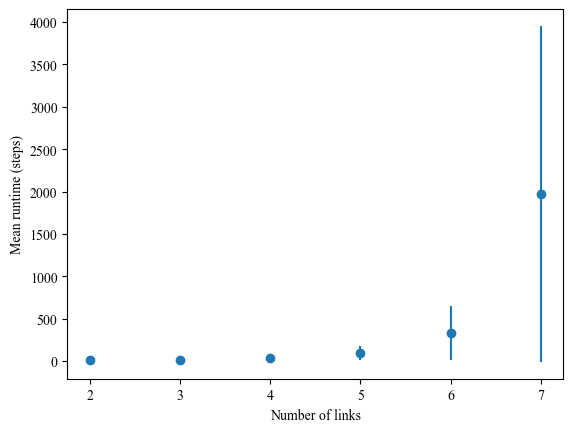

In [14]:
plt.errorbar(links, means_opt, yerr=stds_opt_std, fmt='o')
# plt.title('Mean runtime of optimal policy')
plt.xlabel('Number of links')
plt.xticks(links)
plt.ylabel('Mean runtime (steps)')
plt.show()

Mean runtime for random policy for 2 links: 14.911
Mean runtime for random policy for 3 links: 26.292
Mean runtime for random policy for 4 links: 77.264
Mean runtime for random policy for 5 links: 446.451
Mean runtime for random policy for 6 links: 4385.643
Mean runtime for random policy for 7 links: 456070.692


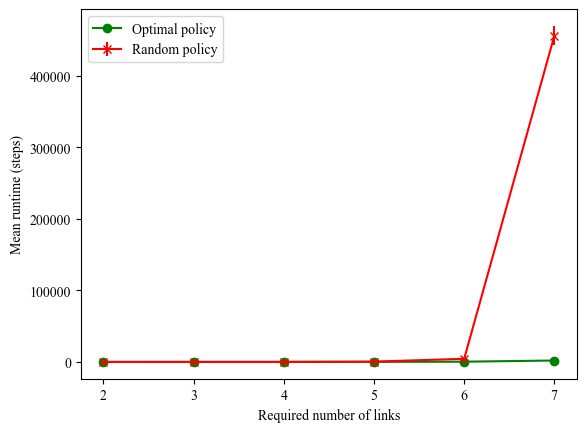

In [15]:
means_random = []
stds_random = []
n_episodes = 1000

for n_links, opt_policy in policies.items():
    random_policy = { s: np.random.randint(0, len(actions)) for s in opt_policy.keys() }
    simulator = Simulator(random_policy, n_links, f_thresh, actions, alpha, gamma)
    random_samples = sim.gen_policy_samples(simulator, n_episodes)
    print(f'Mean runtime for random policy for {n_links} links:', np.mean(random_samples))

    means_random.append(np.mean(random_samples))
    stds_random.append(np.std(random_samples) / np.sqrt(n_episodes))

plt.errorbar(links, means_opt, color='g', marker='o', label='Optimal policy')
plt.errorbar(links, means_random, yerr=stds_random, color='r', marker='x', label='Random policy')

# plt.title('Mean runtime for optimal and random policies')
plt.xlabel('Required number of links')
plt.ylabel('Mean runtime (steps)')
plt.xticks(links)
plt.legend()
plt.show()

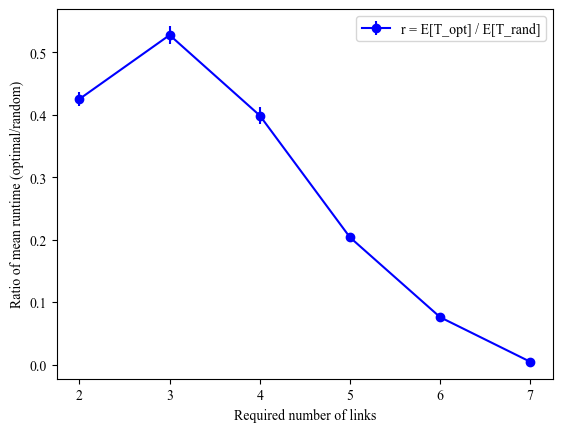

In [16]:
plt.errorbar(links, np.array(means_opt) / np.array(means_random), yerr=[ratio_std(m_x, sigma_x, m_y, sigma_y) for m_x, sigma_x, m_y, sigma_y in zip(means_opt, stds_opt, means_random, stds_random)], color='b', marker='o', label='r = E[T_opt] / E[T_rand]')
# plt.title('Mean runtime ratio for optimal and random policies')
plt.xlabel('Required number of links')
plt.ylabel('Ratio of mean runtime (optimal/random)')
plt.xticks(links)
plt.legend()
plt.show()

Mean runtime for heuristic policy for 2 links: 6.272
Mean runtime for heuristic policy for 3 links: 24.283
Mean runtime for heuristic policy for 4 links: 55.408
Mean runtime for heuristic policy for 5 links: 274.894
Mean runtime for heuristic policy for 6 links: 783.3
Mean runtime for heuristic policy for 7 links: 5737.315


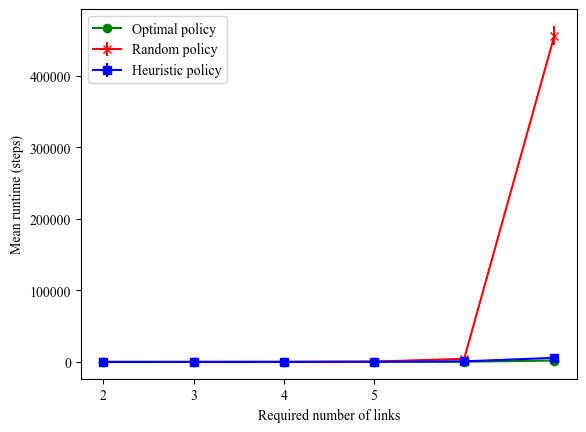

In [17]:
def get_heuristic_action(state: list[int]):
    """
    Returns the action with highest probability that can produce
    a link which can live until the required number of links
    have been generated

    :param list[int] state: The current links in memory
    :returns int: The index of the action to take
    """
    
    state = trim_state(state, n_links)
    req_steps = n_links - len(state)
    min_diff = np.inf
    best_action = 0

    for action_idx, action in enumerate(actions):
        new_ttl = get_ttl(action, alpha, f_thresh, gamma)
        if new_ttl >= req_steps and new_ttl - req_steps < min_diff:
            min_diff = new_ttl - req_steps
            best_action = action_idx
    
    return best_action

def get_heuristic_policy(n_links: int):
    """
    Returns a policy that always takes the action with the highest
    probability of producing a link that can live until the required
    number of links have been generated

    :returns dict: The heuristic policy
    """

    result = {}
    heuristic_env = Environment(n_links, actions, f_thresh, alpha, gamma)
    for state in heuristic_env.states:
        result[str(state)] = get_heuristic_action(state)

    return result

means_heuristic = []
stds_heuristic = []

for n_links in links:
    heuristic_policy = get_heuristic_policy(n_links)
    simulator = Simulator(heuristic_policy, n_links, f_thresh, actions, alpha, gamma)
    heuristic_samples = sim.gen_policy_samples(simulator, n_episodes)
    print(f'Mean runtime for heuristic policy for {n_links} links:', np.mean(heuristic_samples))

    means_heuristic.append(np.mean(heuristic_samples))
    stds_heuristic.append(np.std(heuristic_samples) / np.sqrt(n_episodes))

plt.errorbar(links, means_opt, color='g', marker='o', label='Optimal policy')
plt.errorbar(links, means_random, yerr=stds_random, color='r', marker='x', label='Random policy')
plt.errorbar(links, means_heuristic, yerr=stds_heuristic, color='b', marker='s', label='Heuristic policy')

# plt.title('Mean runtime for optimal and random policies')
plt.xlabel('Required number of links')
plt.ylabel('Mean runtime (steps)')
plt.xticks(range(2, 6))
plt.legend()
plt.show()

[1.01050702 0.57106618 0.55581144 0.33055978 0.42396783 0.34370513]


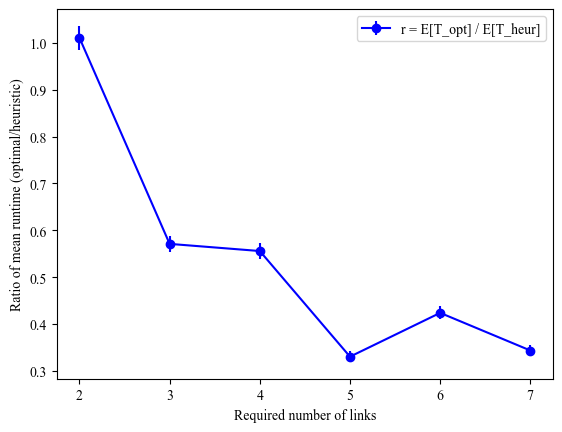

In [18]:
plt.errorbar(links, np.array(means_opt) / np.array(means_heuristic), yerr=[ratio_std(m_x, sigma_x, m_y, sigma_y) for m_x, sigma_x, m_y, sigma_y in zip(means_opt, stds_opt, means_heuristic, stds_heuristic)], color='b', marker='o', label='r = E[T_opt] / E[T_heur]')
print(np.array(means_opt) / np.array(means_heuristic))
# plt.title('Mean runtime ratio for optimal and heuristic policies')
plt.xlabel('Required number of links')
plt.ylabel('Ratio of mean runtime (optimal/heuristic)')
plt.xticks(links)
plt.legend()
plt.show()

In [19]:
means_sp = []
stds_sp = []

for n_links, policy in policies.items():
    sp_samples = {}

    for action_idx, action in enumerate(actions):
        subopt_policy = {s: 0 for s in policy.keys()}

        try:
            simulator = Simulator(subopt_policy, n_links, f_thresh, [action], alpha, gamma)
        except AssertionError:
            sp_samples[action_idx] = [np.inf]
            continue

        sp_samples[action_idx] = sim.gen_policy_samples(simulator, n_episodes)
        print(f'Mean runtime for suboptimal policy for {n_links} links and action {action}:', np.mean(sp_samples[action_idx]))

    means_sp.append([np.mean(sp_samples[i]) for i in range(len(actions)) if sp_samples[i]])
    stds_sp.append([np.std(sp_samples[i]) / np.sqrt(n_episodes) for i in range(len(actions)) if sp_samples[i]])

Mean runtime for suboptimal policy for 2 links and action 0.1: 26.829
Mean runtime for suboptimal policy for 2 links and action 0.2: 11.403
Mean runtime for suboptimal policy for 2 links and action 0.3: 8.069
Mean runtime for suboptimal policy for 2 links and action 0.4: 6.252
Mean runtime for suboptimal policy for 3 links and action 0.1: 84.13
Mean runtime for suboptimal policy for 3 links and action 0.2: 27.978
Mean runtime for suboptimal policy for 3 links and action 0.3: 18.511
Mean runtime for suboptimal policy for 3 links and action 0.4: 24.926
Mean runtime for suboptimal policy for 4 links and action 0.1: 386.849
Mean runtime for suboptimal policy for 4 links and action 0.2: 86.552
Mean runtime for suboptimal policy for 4 links and action 0.3: 69.953


/Users/bggoranoff/workplace/AdaptiveResourceGeneration/OptimalNearTerm/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Mean runtime for suboptimal policy for 5 links and action 0.1: 2674.73
Mean runtime for suboptimal policy for 5 links and action 0.2: 462.51
Mean runtime for suboptimal policy for 5 links and action 0.3: 575.542
Mean runtime for suboptimal policy for 6 links and action 0.1: 27734.897
Mean runtime for suboptimal policy for 6 links and action 0.2: 4172.805
Mean runtime for suboptimal policy for 7 links and action 0.1: 501463.513
Mean runtime for suboptimal policy for 7 links and action 0.2: 97212.484


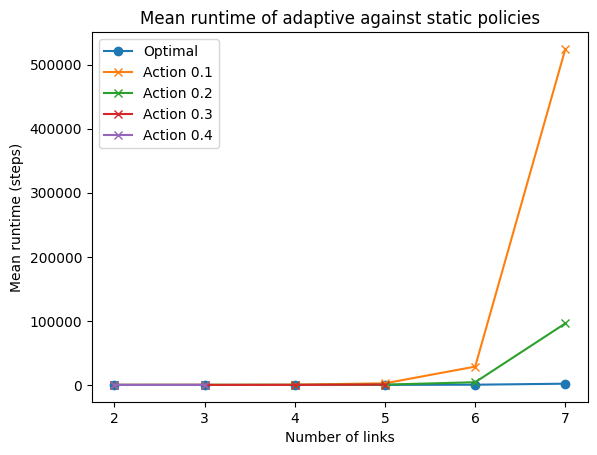

In [58]:
fig, ax = plt.subplots()
ax.plot(links, means_opt, label="Optimal", marker="o")
for action_idx, action in enumerate(actions):
    ax.errorbar(links, [means_sp[i][action_idx] for i in range(len(means_sp))], label=f"Action {action}", marker="x")
ax.set_xlabel("Number of links")
ax.set_ylabel("Mean runtime (steps)")
# ax.set_title("Mean runtime of adaptive against static policies")
ax.legend()
plt.show()

[0.55580987 0.49564658 0.35581385 0.19646905 0.07958531 0.02028489]


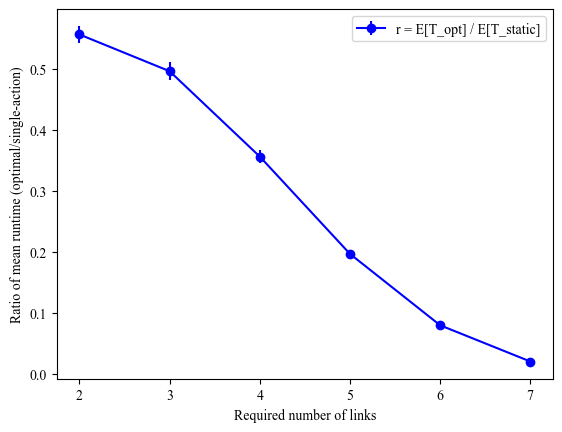

In [20]:
means_sa2 = [means_sp[i][1] for i in range(len(means_sp))]
stds_sa2 = [stds_sp[i][1] for i in range(len(stds_sp))]

print(np.array(means_opt) / np.array(means_sa2))
plt.errorbar(links, np.array(means_opt) / np.array(means_sa2), yerr=[ratio_std(m_x, 0, m_y, sigma_y) for m_x, m_y, sigma_y in zip(means_opt, means_sa2, stds_sa2)], color='b', marker='o', label='r = E[T_opt] / E[T_static]')
# plt.title('Mean runtime ratio for optimal and single-action policy')
plt.xlabel('Required number of links')
plt.ylabel('Ratio of mean runtime (optimal/single-action)')
plt.xticks(links)
plt.legend()
plt.show()